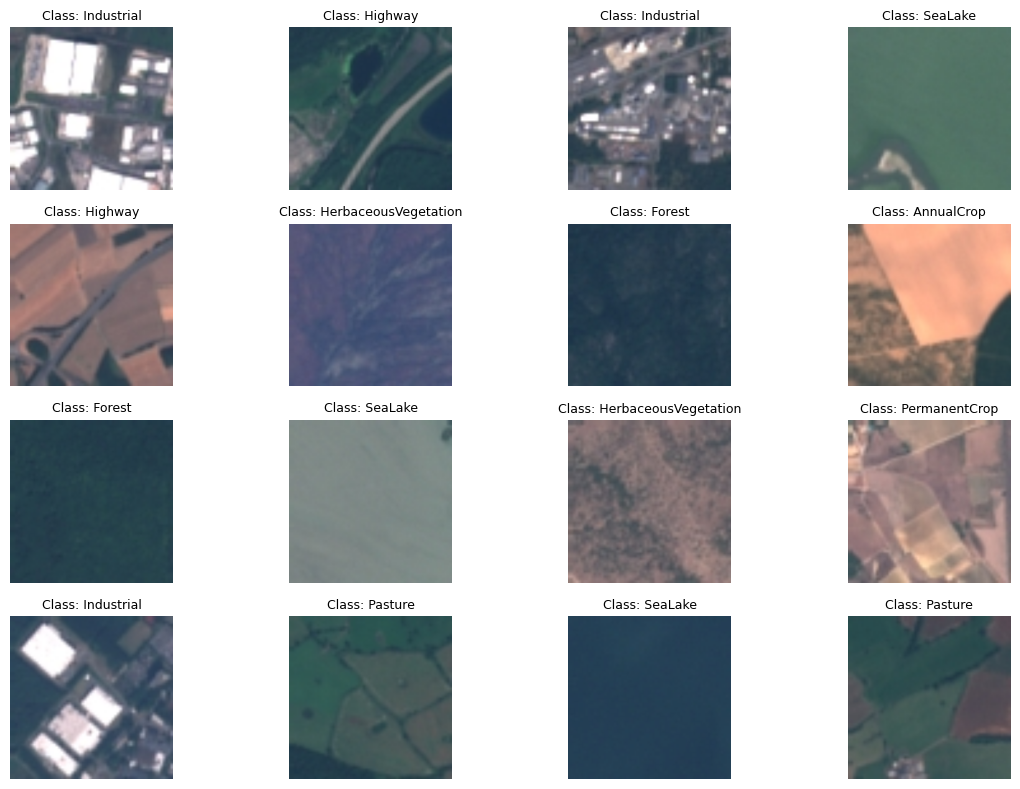

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

data_root = 'root folder with extracted zarr files'
# --- Transform (same as training) ---
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# --- Load Dataset ---
test_set = datasets.ImageFolder(root=data_root, transform=transform)
class_names = test_set.classes

# Split same way as training
from torch.utils.data import random_split
train_size = int(0.8 * len(test_set))
test_size = len(test_set) - train_size
_, test_set = random_split(test_set, [train_size, test_size])

test_loader = DataLoader(test_set, batch_size=16, shuffle=True)


# --- Visualization Helper ---
def imshow(img, mean=0.5, std=0.5):
    img = img * std + mean  # unnormalize
    img = img.numpy().transpose((1, 2, 0))
    return np.clip(img, 0, 1)

# --- Run a Batch of Predictions ---
with torch.no_grad():
    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    

# --- Plot Results ---
images = images.cpu()
labels = labels.cpu()

plt.figure(figsize=(12, 8))
for idx in range(min(16, len(images))):
    plt.subplot(4, 4, idx+1)
    plt.imshow(imshow(images[idx]))
    plt.title(f"Class: {class_names[labels[idx]]}", fontsize=9)
    plt.axis('off')

plt.tight_layout()
plt.show()


Epoch   1 | Loss: 167.7208 | Train Acc: 70.64%


Test Accuracy @ Epoch   1: 78.63%


Epoch   2 | Loss: 111.5207 | Train Acc: 77.98%


Test Accuracy @ Epoch   2: 80.44%


Epoch   3 | Loss: 101.8581 | Train Acc: 79.28%


Test Accuracy @ Epoch   3: 81.17%


Epoch   4 | Loss: 96.3740 | Train Acc: 80.13%


Test Accuracy @ Epoch   4: 81.74%


Epoch   5 | Loss: 92.5814 | Train Acc: 80.72%


Test Accuracy @ Epoch   5: 82.17%


Epoch   6 | Loss: 90.5230 | Train Acc: 81.30%


Test Accuracy @ Epoch   6: 82.00%


Epoch   7 | Loss: 88.5677 | Train Acc: 81.65%


Test Accuracy @ Epoch   7: 82.44%


Epoch   8 | Loss: 86.3370 | Train Acc: 81.95%


Test Accuracy @ Epoch   8: 82.76%


Epoch   9 | Loss: 85.2870 | Train Acc: 82.05%


Test Accuracy @ Epoch   9: 83.35%


Epoch  10 | Loss: 83.3101 | Train Acc: 82.48%


Test Accuracy @ Epoch  10: 83.48%


Epoch  11 | Loss: 81.9593 | Train Acc: 82.75%


Test Accuracy @ Epoch  11: 83.93%


Epoch  12 | Loss: 81.3858 | Train Acc: 82.76%


Test Accuracy @ Epoch  12: 83.69%


Epoch  13 | Loss: 80.6433 | Train Acc: 83.13%


Test Accuracy @ Epoch  13: 83.83%


Epoch  14 | Loss: 79.4217 | Train Acc: 83.34%


Test Accuracy @ Epoch  14: 83.98%


Epoch  15 | Loss: 78.9008 | Train Acc: 83.45%


Test Accuracy @ Epoch  15: 84.15%



Final Linear Evaluation Accuracy on EuroSAT: 84.15%
Final model weights saved as 'linear_head_eurosat_final_weights.pth'


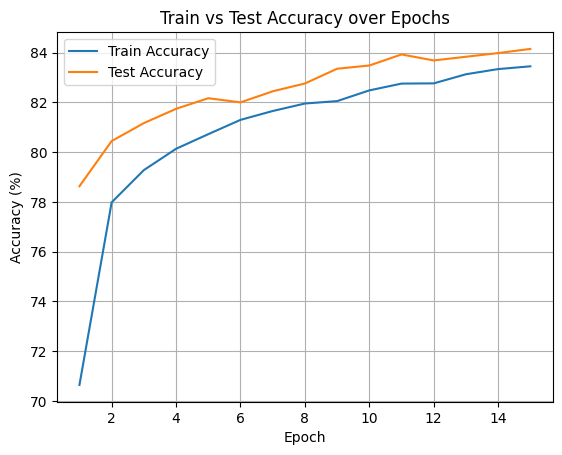

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import matplotlib.pyplot as plt
from Model.utils import *

# --- Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Load pretrained encoder and attach linear classifier ---
encoder = load_pretrained_encoder(
    './checkpoints_new_backbone/simsiam_encoder.pth',
    backbone='resnet18'
)
model = create_linear_classifier(encoder, num_classes=10, freeze_encoder=True).to(device)

# --- EuroSAT Dataset ---
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

data_root = './data/EuroSAT/2750'

train_set = datasets.ImageFolder(root=data_root, transform=transform)
num_classes = len(train_set.classes)

train_size = int(0.8 * len(train_set))
test_size = len(train_set) - train_size
train_set, test_set = random_split(train_set, [train_size, test_size])

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=4)

# --- Training setup ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model[-1].parameters(), lr=0.001)
writer = SummaryWriter(log_dir='../runs/linear_eval_eurosat_fix_15')

# --- Track performance ---
train_accuracies = []
test_accuracies = []

# --- Training Loop ---
for epoch in range(15):
    model.train()
    correct, total, total_loss = 0, 0, 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1:03d}", leave=False)
    for x, y in pbar:
        x, y = x.to(device), y.to(device)

        logits = model(x)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

        pbar.set_postfix({
            'Loss': f"{loss.item():.4f}",
            'Acc': f"{100 * correct / total:.2f}%"
        })

    acc = 100 * correct / total
    train_accuracies.append(acc)
    writer.add_scalar('Train/Loss', total_loss / len(train_loader), epoch + 1)
    writer.add_scalar('Train/Accuracy', acc, epoch + 1)
    print(f"Epoch {epoch+1:3d} | Loss: {total_loss:.4f} | Train Acc: {acc:.2f}%")

    # --- Evaluate every epoch ---
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for x, y in tqdm(test_loader, desc=f"Eval @ Epoch {epoch+1}", leave=False):
            x, y = x.to(device), y.to(device)
            preds = model(x).argmax(dim=1)
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_acc = 100 * test_correct / test_total
    test_accuracies.append(test_acc)
    writer.add_scalar('Test/Accuracy', test_acc, epoch + 1)
    print(f"Test Accuracy @ Epoch {epoch+1:3d}: {test_acc:.2f}%")

# --- Final Evaluation ---
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Final Evaluation", leave=False):
        x, y = x.to(device), y.to(device)
        preds = model(x).argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

final_test_acc = 100 * correct / total
writer.add_scalar('Test/Accuracy', final_test_acc, 50)
print(f"\nFinal Linear Evaluation Accuracy on EuroSAT: {final_test_acc:.2f}%")

print("Final model weights saved as 'linear_head_eurosat_final_weights.pth'")

# --- Plot Accuracy Curve ---
plt.figure()
plt.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, len(test_accuracies)+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Test Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_plot.png')
plt.show()


### Train end to end from a randomly initialized backbone

In [ ]:
import torchvision.models as models
import torch.nn as nn

def load_new_encoder(backbone='resnet50'):
    """Load new encoder for downstream tasks"""
    
    # Initialize encoder
    if backbone == 'resnet50':
        encoder = models.resnet50(weights=None)
        encoder.fc = nn.Identity()
    elif backbone == 'resnet18':
        encoder = models.resnet18(weights=None)
        encoder.fc = nn.Identity()
    
    # Load weights    
    return encoder

Epoch   1 | Loss: 167.0676 | Train Acc: 71.23%


Test Accuracy @ Epoch   1: 78.78%


Epoch   2 | Loss: 111.9171 | Train Acc: 78.10%


Test Accuracy @ Epoch   2: 80.89%


Epoch   3 | Loss: 102.3890 | Train Acc: 79.29%


Test Accuracy @ Epoch   3: 81.20%


Epoch   4 | Loss: 97.0606 | Train Acc: 80.18%


Test Accuracy @ Epoch   4: 82.07%


Epoch   5 | Loss: 93.8350 | Train Acc: 80.74%


Test Accuracy @ Epoch   5: 82.39%


Epoch   6 | Loss: 91.2140 | Train Acc: 81.25%


Test Accuracy @ Epoch   6: 83.04%


Epoch   7 | Loss: 89.0399 | Train Acc: 81.64%


Test Accuracy @ Epoch   7: 83.19%


Epoch   8 | Loss: 87.0098 | Train Acc: 82.05%


Test Accuracy @ Epoch   8: 83.39%


Epoch   9 | Loss: 85.8828 | Train Acc: 82.30%


Test Accuracy @ Epoch   9: 83.37%


Epoch  10 | Loss: 84.5044 | Train Acc: 82.34%


Test Accuracy @ Epoch  10: 83.63%


Epoch  11 | Loss: 83.9484 | Train Acc: 82.39%


Test Accuracy @ Epoch  11: 84.09%


Epoch  12 | Loss: 82.6896 | Train Acc: 82.50%


Test Accuracy @ Epoch  12: 84.28%


Epoch  13 | Loss: 81.9868 | Train Acc: 82.98%


Test Accuracy @ Epoch  13: 84.09%


Epoch  14 | Loss: 80.1871 | Train Acc: 83.19%


Test Accuracy @ Epoch  14: 84.52%


Epoch  15 | Loss: 79.2847 | Train Acc: 83.44%


Test Accuracy @ Epoch  15: 84.91%



Final Linear Evaluation Accuracy on EuroSAT: 84.91%
Final model weights saved as 'linear_head_eurosat_final_weights.pth'


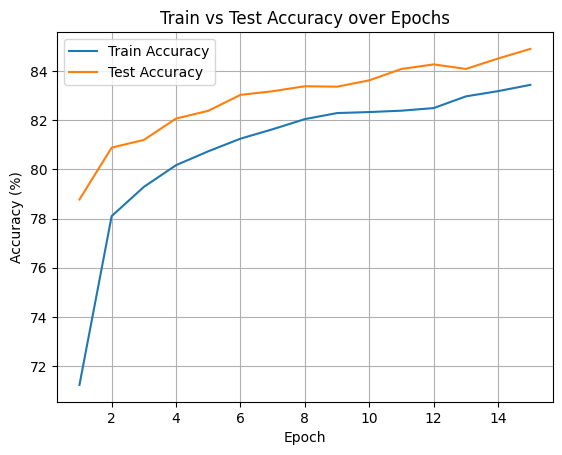

In [ ]:
import torch
from torch import nn, optim
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import matplotlib.pyplot as plt
from Model.utils import *

# --- Setup ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = load_new_encoder(
    backbone='resnet18'
)
model_new = create_linear_classifier(encoder, num_classes=10, freeze_encoder=False).to(device)


# --- Training setup ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_new[-1].parameters(), lr=0.001)
writer = SummaryWriter(log_dir='../runs/random_init')

# --- Track performance ---
train_accuracies_random = []
test_accuracies_random = []

# --- Training Loop ---
for epoch in range(15):
    model_new.train()
    correct, total, total_loss = 0, 0, 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1:03d}", leave=False)
    for x, y in pbar:
        x, y = x.to(device), y.to(device)

        logits = model_new(x)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

        pbar.set_postfix({
            'Loss': f"{loss.item():.4f}",
            'Acc': f"{100 * correct / total:.2f}%"
        })

    acc = 100 * correct / total
    train_accuracies_random.append(acc)
    writer.add_scalar('Train/Loss', total_loss / len(train_loader), epoch + 1)
    writer.add_scalar('Train/Accuracy', acc, epoch + 1)
    print(f"Epoch {epoch+1:3d} | Loss: {total_loss:.4f} | Train Acc: {acc:.2f}%")

    # --- Evaluate every epoch ---
    model_new.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for x, y in tqdm(test_loader, desc=f"Eval @ Epoch {epoch+1}", leave=False):
            x, y = x.to(device), y.to(device)
            preds = model_new(x).argmax(dim=1)
            test_correct += (preds == y).sum().item()
            test_total += y.size(0)

    test_acc = 100 * test_correct / test_total
    test_accuracies_random.append(test_acc)
    writer.add_scalar('Test/Accuracy', test_acc, epoch + 1)
    print(f"Test Accuracy @ Epoch {epoch+1:3d}: {test_acc:.2f}%")

# --- Final Evaluation ---
model_new.eval()
correct, total = 0, 0
with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Final Evaluation", leave=False):
        x, y = x.to(device), y.to(device)
        preds = model_new(x).argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

final_test_acc = 100 * correct / total
writer.add_scalar('Test/Accuracy', final_test_acc, 50)
print(f"\nFinal Linear Evaluation Accuracy on EuroSAT: {final_test_acc:.2f}%")

# --- Save Model ---
#torch.save(model_new.state_dict(), 'linear_head_eurosat_final_weights_2.pth')
print("Final model weights saved as 'linear_head_eurosat_final_weights.pth'")

# --- Plot Accuracy Curve ---
plt.figure()
plt.plot(range(1, len(train_accuracies_random)+1), train_accuracies_random, label='Train Accuracy')
plt.plot(range(1, len(test_accuracies_random)+1), test_accuracies_random, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Train vs Test Accuracy over Epochs')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_plot.png')  # Save the plot
plt.show()


### Compare both

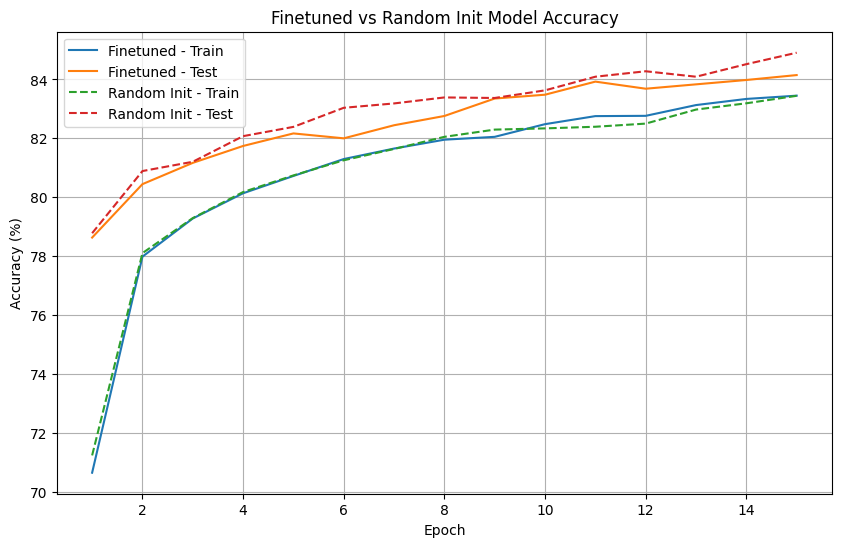

In [29]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_accuracies) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Finetuned - Train')
plt.plot(epochs, test_accuracies, label='Finetuned - Test')

plt.plot(epochs, train_accuracies_random, label='Random Init - Train', linestyle='--')
plt.plot(epochs, test_accuracies_random, label='Random Init - Test', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Finetuned vs Random Init Model Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('finetuned_vs_random.png')
plt.show()
